<p>
Prepared by Vytautas Bielinskas. 2020. <br>
Download data from: https://finance.yahoo.com/quote/GOOG/history/
</p>

<h2>PART 1. Data Pre-processing</h2>

<h3>Step #0. Fire the system</h3>

In [1]:
# Import modules and packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import datetime
import plotly.graph_objects as go # for visualization
import os
import sys 
sys.path.append("../Function/")
from function import remove_high_corr,remove_outliers,plot_line,plot_residuals

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard

%matplotlib inline

<h3>Step #1. Read data</h3>

In [2]:
# Importing Training Set
df = pd.read_excel('../../site_info_ver_4_lite.xlsx')


In [3]:
print(df.columns)
dataset = df[df.Site_Name==df.Site_Name.unique()[1]]
site_name=df.Site_Name.unique()[1]
# dataset_train.set_index("Date",inplace=True)
dataset.head(1)
dataset[['so2','nox','pm10','pm2.5']].isna().sum()


Index(['Date', 'Site_Name', 'Israelis_Count', 'Tourists_Count', 'Total',
       'region_Central', 'region_Judea_Samaria', 'region_North',
       'region_South', 'is_weekend', 'operations', 'is_jewish_holiday',
       'is_jewish_vacation', 'is_muslims_holiday', 'is_muslims_vacation',
       'is_camping', 'special_activity', 'visit_duration', 'is_jewishHeritage',
       'is_muslimsHeritage', 'is_christiansHeritage', 'is_nationalPark',
       'is_natureReserve', 'is_archaeology', 'is_religion', 'is_animals',
       'is_heritage', 'is_water', 'is_cave', 'is_lookout', 'pm10', 'pm2.5',
       'nox', 'so2', 'Temperature', 'is_HeatWave', 'Tel_Aviv-Yafo_pm10',
       'Jerusalem_pm10', 'Haifa_pm10', 'Ashkelon_pm10', 'Beer-Sheva_pm10',
       'Tel_Aviv-Yafo_pm2.5', 'Jerusalem_pm2.5', 'Haifa_pm2.5',
       'Ashkelon_pm2.5', 'Beer-Sheva_pm2.5', 'Tel_Aviv-Yafo_nox',
       'Jerusalem_nox', 'Haifa_nox', 'Ashkelon_nox', 'Beer-Sheva_nox',
       'Tel_Aviv-Yafo_so2', 'Jerusalem_so2', 'Haifa_so2', 'Ashke

so2      361
nox        0
pm10       0
pm2.5      0
dtype: int64

In [4]:
n_predict = 1   # Number of days we want top predict into the future
n_past = 7     # Number of past days we want to use to predict the future
cols = ['Temperature','pm10','Tel_Aviv-Yafo_pm10','Israelis_Count']
target='Israelis_Count'
target_title='Israelis'
def X_y_data(dataset):
    # Select features (columns) to be involved intro training and predictions

    # Extract dates (will be used in visualization)
    datelist = list(dataset['Date'])
    
    # datelist = [dt.datetime.strptime(date, '%Y-%m-%d').date() for date in datelist]
    dataset=dataset.set_index('Date')
    print('set shape == {}'.format(dataset.shape))
    print('All timestamps == {}'.format(len(datelist)))
    print('Featured selected: {}'.format(cols))
    dataset = dataset[cols].astype(str)
    for i in cols:
        for j in dataset.index:
            dataset[i][j] = dataset[i][j].replace(',', '')

    dataset = dataset.astype(float)

    # Using multiple features (predictors)
    training_set = dataset.values

    print('Shape of set == {}.'.format(training_set.shape))
    print(training_set)

    #first get log from visitors : 
    
    a = training_set[:,:-1]
    b = np.log(training_set[:,-1]+0.001)
    print('a',a.shape,a)
    print('b',b.shape,b)
    # np.reshape(b, b.shape[0],)
    training_set = np.insert(a, len(cols)-1,values=b, axis=1) # Insert values before column 3

    print('training_set\n',training_set)
    # Feature Scaling
    from sklearn.preprocessing import StandardScaler

    sc = StandardScaler()
    training_set_scaled = sc.fit_transform(training_set)

    sc_predict = StandardScaler()
    sc_predict.fit_transform(training_set[:, -1:])
    # Creating a data structure with 90 timestamps and 1 output
    X_train = []
    y_train = []



    for i in range(n_past, len(training_set_scaled) - n_predict +1):
        X_train.append(training_set_scaled[i - n_past:i,:])
        y_train.append(training_set_scaled[i + n_predict - 1:i + n_predict,-1])
    print()

    return dataset,datelist,np.array(X_train), np.array(y_train),sc_predict
size = round(len(dataset)*.8)

dataset_train = dataset[:size]
dataset_test = dataset[size:]
print('Training print')
print()
dataset_train,datelist_train,X_train, y_train,sc_predict_train = X_y_data(dataset_train)

print('Testing print')
print()
dataset_test,datelist_test,X_test, y_test,sc_predict_test = X_y_data(dataset_test)

print('X_train shape == {}.'.format(X_train.shape))
print('y_train shape == {}.'.format(y_train.shape))
print('X_test shape == {}.'.format(X_test.shape))
print('y_test shape == {}.'.format(y_test.shape))


Training print

set shape == (1516, 85)
All timestamps == 1516
Featured selected: ['Temperature', 'pm10', 'Tel_Aviv-Yafo_pm10', 'Israelis_Count']
Shape of set == (1516, 4).
[[ 14.1  25.6  64.1   5. ]
 [ 12.3  23.5 154.1  76. ]
 [ 16.3 223.5  29.9  14. ]
 ...
 [ 28.5  74.1 127.2 176. ]
 [ 35.3  46.5 205.  433. ]
 [ 40.4 204.6 232.9 498. ]]
a (1516, 3) [[ 14.1  25.6  64.1]
 [ 12.3  23.5 154.1]
 [ 16.3 223.5  29.9]
 ...
 [ 28.5  74.1 127.2]
 [ 35.3  46.5 205. ]
 [ 40.4 204.6 232.9]]
b (1516,) [1.60963789 4.3307465  2.63912876 ... 5.17048968 6.07074004 6.21060209]
training_set
 [[ 14.1         25.6         64.1          1.60963789]
 [ 12.3         23.5        154.1          4.3307465 ]
 [ 16.3        223.5         29.9          2.63912876]
 ...
 [ 28.5         74.1        127.2          5.17048968]
 [ 35.3         46.5        205.           6.07074004]
 [ 40.4        204.6        232.9          6.21060209]]

Testing print

set shape == (379, 85)
All timestamps == 379
Featured selected: ['T

<h2>PART 2. Create a model. Training</h2>

<h3>Step #3. Building the LSTM based Neural Network</h3>

In [5]:
# Import Libraries and packages from Keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
# from keras.optimizers import ADAM

In [14]:
from keras import backend
 
def rmse(y_true, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_true), axis=-1))

# Initializing the Neural Network based on LSTM
model = Sequential()

# Adding 1st LSTM layer
model.add(LSTM(units=128, return_sequences=True, input_shape=(n_past, dataset_train.shape[1])))
# Adding Dropout
model.add(Dropout(0.35))
# Adding 2nd LSTM layer
model.add(LSTM(units=128, return_sequences=False))
# Adding Dropout
model.add(Dropout(0.25))
# Output layer
model.add(Dense(units=1))

# Compiling the Neural Network
model.compile(optimizer = 'adam', loss=[rmse],metrics='mean_squared_error')

<h3>Step #4. Start training</h3>

In [16]:
%%time
es = EarlyStopping(monitor='val_loss', min_delta=1e-10, patience=20, verbose=1)
rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=20, verbose=1)
mcp = ModelCheckpoint(filepath='weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True)

tb = TensorBoard('logs')

history = model.fit(X_train, y_train, shuffle=True, epochs=1000, callbacks=[es, rlr, mcp, tb], validation_split=0.2, verbose=1, batch_size=1)

Epoch 1/1000
1207/1207 [==============================] - ETA: 0s - loss: 0.7106 - mean_squared_error: 0.9333
Epoch 00001: val_loss improved from inf to 0.64525, saving model to weights.h5
1207/1207 [==============================] - 15s 12ms/step - loss: 0.7106 - mean_squared_error: 0.9333 - val_loss: 0.6452 - val_mean_squared_error: 0.7252 - lr: 0.0010
Epoch 2/1000
1205/1207 [============================>.] - ETA: 0s - loss: 0.7078 - mean_squared_error: 0.9059

<p>
Notes:<br>
<ul>
<li><b>EarlyStopping</b> - Stop training when a monitored metric has stopped improving.</li>
<li><code>monitor</code> - quantity to be monitored.</li>
<li><code>min_delta</code> - minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than <code>min_delta</code>, will count as no improvement.</li>
<li><code>patience</code> - number of epochs with no improvement after which training will be stopped.</li>
</ul>

<ul>
<li><b>ReduceLROnPlateau</b> - Reduce learning rate when a metric has stopped improving.</li>
<li><code>factor</code> - factor by which the learning rate will be reduced. <code>new_lr = lr * factor</code>.</li>
</ul>
</p>

<hr>

<p>
The last date for our training set is <code>30-Dec-2016</code>.<br>
</p>

<p>
We will perform predictions for the next <b>20</b> days, since <b>2017-01-01</b> to <b>2017-01-20</b>.
</p>

<h2>PART 3. Make future predictions</h2>

In [ ]:
# # Generate list of sequence of days for predictions
# datelist_future = pd.date_range(datelist_train[-1], periods=n_predict, freq='1d').tolist()
# datelist_future


In [ ]:
'''
Remeber, we have datelist_train from begining.
'''

# Convert Pandas Timestamp to Datetime object (for transformation) --> FUTURE
datelist_future_ = []
for this_timestamp in datelist_test:
    datelist_future_.append(this_timestamp.date())
# datelist_future_

<h3>Step #5. Make predictions for future dates</h3>

In [ ]:
# Perform predictions
predictions_future = model.predict(X_test)
len(predictions_future)
# predictions_train = model.predict(X_train[n_past:])

372

In [ ]:
# Inverse the predictions to original measurements

# ---> Special function: convert <datetime.date> to <Timestamp>
def datetime_to_timestamp(x):
    '''
        x : a given datetime value (datetime.date)
    '''
    return datetime.strptime(x.strftime('%Y%m%d'), '%Y%m%d')


y_pred_future = np.exp(sc_predict_test.inverse_transform(predictions_future))
# y_pred_train = np.exp(sc_predict_train.inverse_transform(predictions_train))
print(predictions_future.shape)


PREDICTIONS_FUTURE = pd.DataFrame(y_pred_future, columns=[target]).set_index(pd.Series(datelist_test[n_past:]))
# PREDICTION_TRAIN = pd.DataFrame(y_pred_train, columns=[target]).set_index(pd.Series(datelist_train[2 * n_past + n_predict -1:]))

# Convert <datetime.date> to <Timestamp> for PREDCITION_TRAIN
# PREDICTION_TRAIN.index = PREDICTION_TRAIN.index.to_series().apply(datetime_to_timestamp)

PREDICTIONS_FUTURE.head(3)

(372, 1)


,Israelis_Count
2020-05-24,443.967224
2020-05-25,59.303307
2020-05-26,256.191833


<h3>Step #6. Visualize the Predictions</h3>

rmse 374.79963785868347
std test 366.4804863855317


INFO:tensorflow:Assets written to: LSTM_models/model_Eilat/mod1_rmse374.8\assets


INFO:tensorflow:Assets written to: LSTM_models/model_Eilat/mod1_rmse374.8\assets


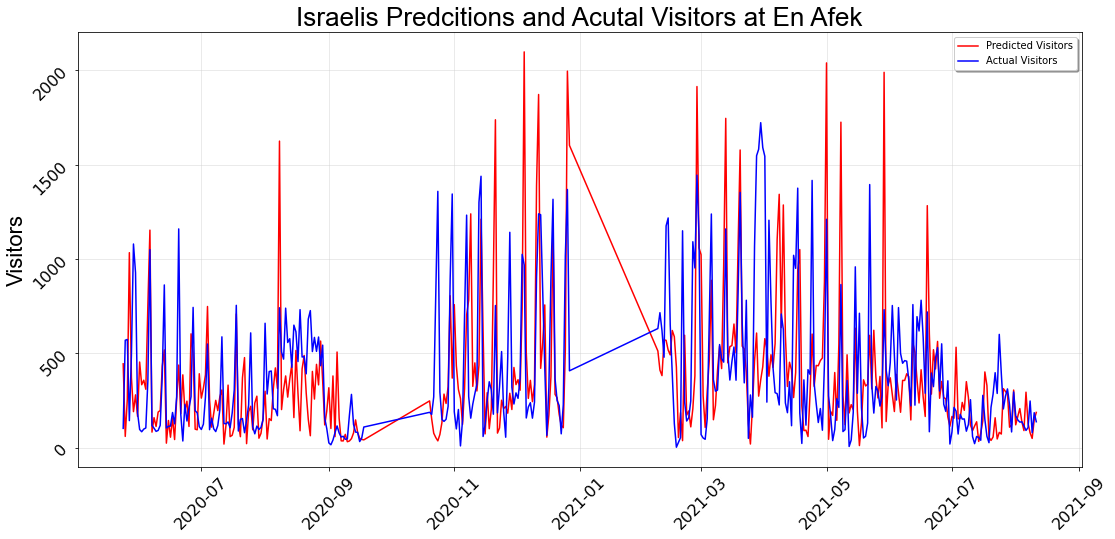

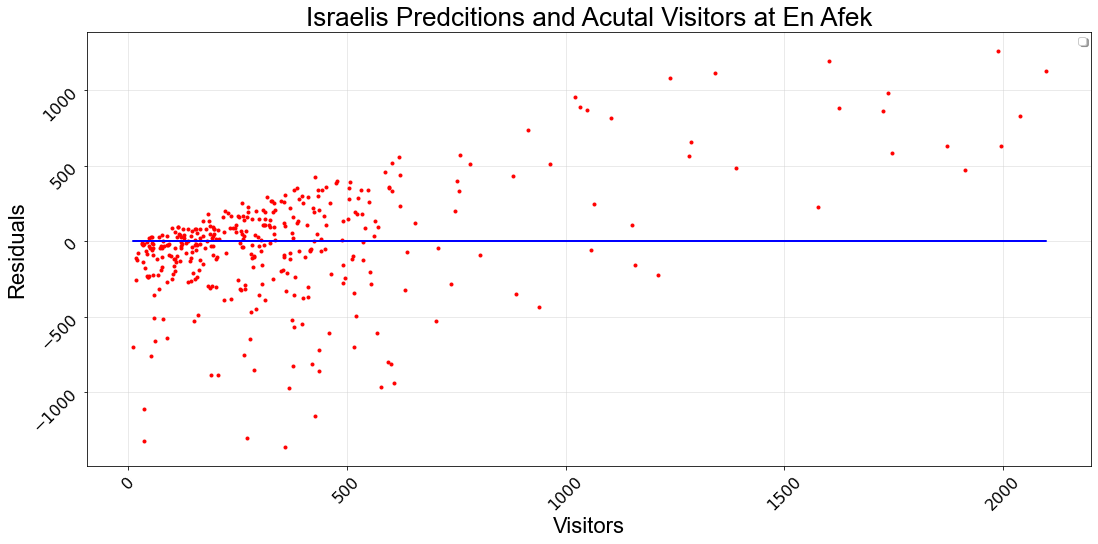

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Set plot size 
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8

res = pd.merge(PREDICTIONS_FUTURE[target], dataset_test[target],left_index=True,right_index=True)
res.columns=['Predictions','Actual']
res['residuals'] = res['Predictions'] - res['Actual']

from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(res['Predictions'],res['Actual']))
print('rmse',rmse)
print('std test',np.std(res['Actual']))

rmse_str = str(round(rmse,2))

# Check whether the specified path exists or not
path = 'LSTM_models/model_Eilat/mod1_rmse'+rmse_str
isExist = os.path.exists(path)
if not isExist:
  os.makedirs(path)
model.save(path)

plot_line(
  predicion=res.Predictions,
  actual=res.Actual,
  title=target_title+' Predcitions and Acutal Visitors at '+site_name,
  path_save='LSTM_models/model_Eilat/',
  file_name='mod1_rmse'+ rmse_str+ '.png'
  )

plot_residuals(
  predicion=res.Predictions,
  actual=res.Actual,
  title=target_title+' Predcitions and Acutal Visitors at '+site_name,
  path_save='LSTM_models/model_Eilat/',
  file_name='mod1_rmse'+ rmse_str+ 'residuals.png'
  )


In [ ]:
# Parse training set timestamp for better visualization
dataset_train = pd.DataFrame(dataset_train, columns=cols)
dataset_train.index = datelist_train
dataset_train.index = pd.to_datetime(dataset_train.index)